#Import Libraries

In [ ]:
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow
from numpy.core.getlimits import inf
import math
from PIL import Image, ImageOps
from collections import Counter
from numpy import asarray
from fractions import Fraction

# Functions For JPEG

>## Class Node

In [ ]:
#create a class to save nodes of the tree that will be concstructed in Huffman encoding
class node:
  def __init__(self, prob, value, left=None, right=None):
    self.prob = prob
    self.value = value
    self.left = left
    self.right = right
    self.code =''
  
  #function to be used in sorting as the key
  def getProb(self):
    return self.prob

>## Arithmetic Encoding & Decoding Functions

In [ ]:
# find the range of each symbol
def rangeChar(char, prob):
  '''
  This function is made to help in arithmetic encoding and decoding
  Input: a list of characters and a list of probabilities
  Output: the upper and lower bounds
  '''
  upperChar = [Fraction(0)] * len(prob)
  lowerChar = [Fraction(0)] * len(prob)
  
  upperChar[0] = prob[0]
  for i in range(1, len(char)):
    lowerChar[i] = upperChar[i-1]
    upperChar[i] = lowerChar[i] + prob[i]
  return upperChar, lowerChar

In [ ]:
def arithEnc(str, char, prob):
  '''
  This function performs arithmetic encoding 
  Input: a string or list of integers or strings to be encoded,
         a list of all characters and a list of their probabilities
  Output: encoded string
  '''
  upperChar, lowerChar = rangeChar(char, prob)
  
  #first we need to find the upper and lower limits
  lowerBound = Fraction(0)
  upperBound = Fraction(1)
  for c in str:
    i = char.index(c)
    currentRange = upperBound - lowerBound
    upperBound = lowerBound + (currentRange * upperChar[i])
    lowerBound = lowerBound + (currentRange * lowerChar[i])
  
  #second step is to use the upper and lower limits to encode the word
  up = Fraction(1)
  mid = Fraction(0.5)
  low = Fraction(0)
  code = ""

  while 1:
    if mid >= lowerBound and up <= upperBound:
      return code
    elif low >= lowerBound and mid <= upperBound:
      return code

    if mid > upperBound:
      code +="0"
      up = mid
      mid = low + (up - low) /2
    else:
      code +="1"
      low = mid
      mid += (up - low) /2

In [ ]:
def arithDec(str, char, prob, numOfSym):
  '''
  This function performs arithmetic deccoding 
  Input: an encoded string, a list of all characters, a list of their probabilities, and the number of symbols
  Output: decoded list of integers or strings
  '''
  upperChar, lowerChar = rangeChar(char, prob)

  #convert the fixed point code to decimal number
  encValue = 0
  for i in range(len(str)):
     encValue += Fraction(str[i])*pow(Fraction(2),-(i+1))

  #iterate using the given number of symbols and find where the calculated value lies in ranges of symbols
  out = []
  for n in range(numOfSym):
    for i in range(len(char)):
      if encValue <= upperChar[i] and encValue >= lowerChar[i]:
        upperBound = upperChar[i]
        lowerBound = lowerChar[i]
        out.append(char[i])
        break
    currentRange = upperBound - lowerBound
    encValue = (encValue - lowerBound) / currentRange
  
  return out

>## Huffman Encoding & Decoding Functions

In [ ]:
def huffenc(values, prob):
  '''
  This function builds a tree for huffman encoding 
  Input: symbols and probailities as two lists
  Output: average length, new codes for the given symbols, and the root of the tree
  '''
  nodes = []
  
  #create leaves from the given inputs(symbols and probabilities) to be used in constructing the tree
  for i in range(len(values)):
    nodes.append(node(prob[i], values[i]))
  
  #Constructing the tree by picking the first two elements in the list 
  #and add there probabilities and making a new node
  while len(nodes)-1:
    nodes.sort(key = node.getProb)
    nodes.append(node(nodes[0].prob+nodes[1].prob,'', nodes[0], nodes[1]))
    nodes.remove(nodes[0])
    nodes.remove(nodes[0])
  
  #give values to each edge where left edge takes 1 and right edge takes 0
  #each node takes a code according to their parent code in addition to the path 
  def coding(root, map):
    if root.left:
      root.left.code = root.code + '1'
      coding(root.left, map)

    if root.right:
      root.right.code = root.code + '0'
      coding(root.right, map)

    if root.left == None and root.right == None:
      map[root.value] = (root.code, root.prob)
  
  #call the helper funciton coding to get the codes for each symbol
  map = {}
  coding(nodes[0], map)

  #calculating average length  
  avL = 0
  for i in map:
    avL = avL + len(map[i][0]) * map[i][1]
  
  return avL, map, nodes[0]

In [ ]:
def huffdec(arr, root):
  '''
  This function performs huffman decoding 
  Input: encoded string or list and root of the tree
  Output: the original values of the symbols before encoding
  '''  
  def symDec(arr, node):
    #if the current node is a leave then return the remaining arr and the value of the leave
    if(node.left ==  None and node.right == None):
      return arr, node.value

    #if the first element in the arr equals one then call symDec recursively with arr without the first element and the left child of the node
    if(arr[0] == '1'):
      return symDec(arr[1:], node.left)

    #if the first element in the arr equals zero then call symDec recursively with arr without the first element and the right child of the node
    else:
      return symDec(arr[1:], node.right)
  
  solution = []
  while(len(arr)):
    arr, symbol = symDec(arr, root)
    solution.append(symbol)
    
  return solution

>## DCT & IDCT

In [ ]:
import numpy as np

def dct_optimized(block_8):
  # Precompute the cosine values
  cosines = np.empty((8, 8, 8, 8))
  for u in range(8):
    for v in range(8):
      cosines[u, v, :, :] = np.cos((1/16)*(2*np.arange(8)+1)*u*np.pi)[:, np.newaxis] * np.cos((1/16)*(2*np.arange(8)+1)*v*np.pi)[np.newaxis, :]

  # Precompute the scaling factors
  alpha1 = np.zeros(8)
  alpha1[0] = 1/np.sqrt(8)
  alpha1[1:] = np.sqrt(2/8)
  alpha2 = np.zeros(8)
  alpha2[0] = 1/np.sqrt(8)
  alpha2[1:] = np.sqrt(2/8)

  # Perform the DCT
  dct_result = np.zeros((8, 8))
  for u in range(8):
    for v in range(8):
      dct_result[u, v] = alpha1[u] * alpha2[v] * np.sum(np.multiply(block_8, cosines[u, v, :, :]))

  return dct_result

In [ ]:
def idct_optimized(block_8):
  # Precompute the cosine values
  cosines = np.empty((8, 8, 8, 8))
  for u in range(8):
    for v in range(8):
      cosines[u, v, :, :] = np.cos((1/16)*(2*np.arange(8)+1)*u*np.pi)[:, np.newaxis] * np.cos((1/16)*(2*np.arange(8)+1)*v*np.pi)[np.newaxis, :]

  # Precompute the scaling factors
  alpha1 = np.zeros(8)
  alpha1[0] = 1/np.sqrt(8)
  alpha1[1:] = np.sqrt(2/8)
  alpha2 = np.zeros(8)
  alpha2[0] = 1/np.sqrt(8)
  alpha2[1:] = np.sqrt(2/8)

  # Perform the IDCT
  idct_result = np.zeros((8, 8))
  for u in range(8):
    for v in range(8):
      idct_result += block_8[u, v] * alpha1[u] * alpha2[v] * cosines[u, v, :, :]

  return idct_result.astype(int)

In [ ]:
def dct(block_8):
  '''
  This function performs dct 
  Input: a 2D list of size 8x8
  Output: a 2D list of size 8x8 after preforming dct
  '''  

  #intialize the basis block
  basis = np.zeros((8,8))

  #looping over the size of the basis and size of the input
  dctResult = np.zeros((8,8))

  # Pre-compute the scaling factors
  alpha1 = np.zeros(8)
  alpha1[0] = 1/math.sqrt(8)
  alpha1[1:] = np.sqrt(2/8)
  alpha2 = np.zeros(8)
  alpha2[0] = 1/math.sqrt(8)
  alpha2[1:] = np.sqrt(2/8)

  for u in range(8):
      for v in range(8):
          for x in range(8):
              for y in range(8):
                  #constructing the basis function
                  basis[x, y]=(np.cos((1/16)*(2*x+1)*u*np.pi))*(np.cos((1/16)*(2*y+1)*v*np.pi))

          #multiplying each pixel to the corresponding basis block and averaging them then storing in dct_result
          dctResult[u,v]= alpha1[u]*alpha2[v]*sum(np.multiply(block_8,basis).flatten())
  
  return dctResult

In [ ]:
def idct(block_8):
  '''
  This function performs idct 
  Input: a 2D list of size 8x8
  Output: a 2D list of size 8x8 after preforming inverse of dct
  ''' 
  # Pre-compute the scaling factors
  alpha1 = np.zeros(8)
  alpha1[0] = 1/math.sqrt(8)
  alpha1[1:] = np.sqrt(2/8)
  alpha2 = np.zeros(8)
  alpha2[0] = 1/math.sqrt(8)
  alpha2[1:] = np.sqrt(2/8)

  #intialize the basis block
  basis = np.zeros((8,8))

  #looping over the size of the basis and size of the input
  idctResult = np.zeros((8,8))
  
  for u in range(8):
      for v in range(8):
          for x in range(8):
              for y in range(8):
                  #constructing the basis block
                  basis[x, y]=(np.cos((1/16)*(2*x+1)*u*np.pi))*(np.cos((1/16)*(2*y+1)*v*np.pi))
            
          # multiplying each value of encoded_block to the corresponding
          # basis block and summing the result and storing it in the result_Idct block
          idctResult=idctResult+np.multiply(block_8[u,v]*alpha1[u]*alpha2[v], basis)
  
  return idctResult.astype(int)

>## Quantization Table

In [ ]:
def quantizationTable(x):
  '''
  This function used to get quantization table
  Input: an integer number from 0 to 2
  Output: a 2D list of size 8x8
  '''  
  if x==0:  #no compression
      table = np.ones((8,8))
      
  elif x==1:  #for Low compression
      table = [[1, 1, 1, 1, 1, 2, 2, 4], [1, 1, 1, 1, 1, 2, 2, 4], [1, 1, 1, 1, 2, 2, 2, 4],
               [1, 1, 1, 1, 2, 2, 4, 8], [1, 1, 2, 2, 2, 2, 4, 8], [2, 2, 2, 2, 2, 4, 8, 8],
               [2, 2, 2, 4, 4, 8, 8, 16], [4, 4, 4, 4, 8, 8, 16, 16]]

  elif x==2:  #for high compression
      table=[[1, 2, 4, 8, 16, 32, 64, 128], [2, 4, 4, 8, 16, 32, 64, 128],
             [4, 4, 8, 16, 32, 64, 128, 128], [8, 8, 16, 32, 64, 128, 128, 256], 
             [16, 16, 32, 64, 128, 128, 256, 256], [32, 32, 64, 128, 128, 256, 256, 256],
             [64, 64, 128, 128, 256, 256, 256, 256], [128, 128, 128, 256, 256, 256, 256, 256]]

  elif x==3: #for Luminance
    table = [[16,	11,	10,	16,	24,	40,	51,	61], [12,	12,	14,	19,	26,	58,	60,	55],
            [14,	13,	16,	24,	40,	57,	69,	56], [14,	17,	22,	29,	51,	87,	80,	62],
            [18,	22,	37,	56,	68,	109,	103,	77], [24,	35,	55,	64,	81,	104,	113,	92],
            [49,	64,	78,	87,	103,	121,	120,	101], [72,	92,	95,	98,	112,	100,	103,	99]]
  
  return table

>## From 2D to 1D
reference for to1D function: https://www.geeksforgeeks.org/print-matrix-in-zig-zag-fashion/

In [ ]:
def to1D(block_8):
  '''
  This function performs zigzag method to convert a 2D matrix to 1D
  Input: a 2D list of size 8x8
  Output: a 1D list
  '''  
  rows = 8
  columns = 8
  solution=[[] for i in range(rows+columns-1)]
  
  for i in range(rows):
      for j in range(columns):
          sum=i+j
          if(sum%2 ==0):
  
              #add at beginning
              solution[sum].insert(0,block_8[i][j])
          else:
  
              #add at end of the list
              solution[sum].append(block_8[i][j])   
                      
  return [item for sublist in solution for item in sublist]

In [ ]:
def to2D(arr):
  '''
  This function performs inverse of zigzag method to convert a 1D list to 2D matrix
  Input: a 1D list of length 64
  Output: a 2D list of size 8x8
  '''  
  rows = 8
  columns = 8
  solution=[[] for i in range(rows+columns-1)]

  j = 0

  for i in range(len(solution)):
    temp = []

    length = i+1

    if(length>rows):
      length = len(solution) - i

    while (1):
      temp = temp + [arr[i+j]]

      if(len(temp) == length):
        break
  
      j = j + 1

    solution[i] = temp

  y = []
  for i in range(rows):
    y.append([0]*columns)
 
  for i in range(len(solution)):
    sublist = solution[i]
    for j in range(len(sublist)):

      if(i+1>rows):
        min = rows - len(sublist)
        max = rows-1
      else:
        min = 0
        max = len(sublist)-1

      if(i%2==0):
        row = max-j
        col = min + j
      else:
        row = min + j
        col = max-j

      y[row][col] = sublist[j]

  return y

>## Run - Length Encoding & Decoding

In [ ]:
def runenc(block_8):
    '''
    This function performs run length encoding 
    Input: a 1D list of any size
    Output: a 1D list of variable size
    '''  
    encoded = []
    i = 0
 
    while (i <= len(block_8)-1):
        count = 1
        ch = block_8[i]
        j = i
        while (j < len(block_8)-1):
            #if the current value equals zero and next value equals zero then increment count and loop again 
            if (block_8[j] == 0 and block_8[j] == block_8[j+1]):
                count = count+1
                j = j+1
            #else break the while loop then add the element to the encoded list
            else:
                break
        encoded.append(ch)
        #if the element equals zero then add count to the encoded list
        if(ch == 0):
          encoded.append(count)
        i = j+1
    return encoded

In [ ]:
def rundec(arr):
    '''
    This function performs run length decoding 
    Input: a 1D list of any size
    Output: a 1D list after performing run length decoding 
    '''  
    decoded = []
    i = 0

    while(i<len(arr)):
      #if the value not equal zero append it
      if(arr[i]):
        decoded.append(arr[i])
        i = i + 1
      #if the value equals zero then create list of zeros with size from the next value and add it to the decoded list
      else:
        decoded = decoded + [0] * int(arr[i+1])
        i = i + 2
    return decoded

>## JPEG

>>### Helper Funtions

In [ ]:
def use_huffenc(runOut):
  '''
  This function calculates probabilities for each unique value in the input 
  and performs huffman encoding 
  Input: a 1D list
  Output: encoded string and the root of the encoding tree
  '''  
  # Get Probabilities
  freq = Counter(runOut)
  value = list(freq.keys())
  prob = np.divide(np.array(list(freq.values())), len(runOut)).tolist()
  
  # Encode
  avL, map, root = huffenc(value, prob)
  huffencoded = ''
  for i in runOut:
    huffencoded = huffencoded + map[i][0]
  return huffencoded, root

In [ ]:
def use_arithenc(runOut, numSym = 128):
  '''
  This function divides a list to sublists 
  and calculates probabilities for each unique value in sublist
  then performs arithmetic encoding for each sublist
  Input: a 1D list
  Output: unique values and their probabilities, encoded list of strings,
          and the number of symbols in each sublist
  '''  

  # Get Probabilities
  freq = Counter(runOut)
  value = list(freq.keys())
  prob = []
  for i in freq.values():
    prob.append(Fraction(i, len(runOut)))
    
  #encode
  encoded = []  
  last_numSym = 0
  for i in range(0, len(runOut), numSym):
    if i+numSym>len(runOut):
      x = runOut[i:len(runOut)]
      last_numSym = len(x)
    else:
      x = runOut[i:i+numSym]
    encoded.append(arithEnc(x, value, prob))

  helper = ((numSym, last_numSym), value, prob)
  return encoded, helper

In [ ]:
def use_arithdec(encoded, helper):
  '''
  This function performs arithmetic decoding for each string in encoded list,
  then put them in one list
  Input: encoded list of strings, unique values and their probabilities,
          and the number of symbols in each encoded string
  Output: list of decoded symbols
  '''  
  numSym = helper[0]
  values = helper[1]
  probs = helper[2]

  decoded = []
  n = numSym[0]
  for i in range(len(encoded)):
    if i == len(encoded) - 1 and numSym[1]:
      n = numSym[1]
    decoded.append(arithDec(encoded[i], values, probs, n))
  return [i for x in decoded for i in x]

>>### Encoding 

In [ ]:
def jpegEnc(q, img, coding_function):
  '''
  This function performs JPEG encoding
  Input: quatization table option as integer, image, 
  and entropy encoding function as string
  Output: encoded string
          and unique helper depends on type of entropy encoding function for decoding
  '''  

  # Divide Into 8x8 Blocks
  blocks = []
  i = 0
  j = 0

  for i in range(0,size,8):
      for j in range(0,size,8):
        blocks.append(img[i:i+8,j:j+8])
  
  #preform DCT
  dctOut = [dct_optimized(block_8) for block_8 in blocks]

  # Use Quantization Table
  qTable = quantizationTable(q)
  qOut = []
  for block_8 in dctOut:
    newBlock = np.divide(block_8, qTable)
    for i in range(len(newBlock)):
      newBlock[i] = [round(item) for item in newBlock[i]]
    qOut.append(newBlock)
  
  # convert to 1D
  arr1D = []
  for block_8 in qOut:
    arr1D.append(to1D(block_8))
  arr1D = np.array(arr1D).flatten()

  # Use Run-Length Encoding
  runOut = runenc(arr1D)

  # Use Entropy coding function to calculate probabilties and encode the run length output
  if coding_function == 'Huffman':
    encoded, helper = use_huffenc(runOut)
  elif coding_function == 'Arithmetic':
    encoded, helper =use_arithenc(runOut)

  return encoded, helper

>>### Decoding

In [ ]:
def jpegDec(q, encoded, helper, coding_function):
  '''
  This function performs JPEG decoding
  Input: quatization table option as integer, encoded string, 
         helper for entropy decoding, and entropy coding function as string
  Output: image
  '''  
  # Use Entropy Decoding function
  if coding_function == 'Huffman':
    decoded = huffdec(encoded, helper)
  elif coding_function == 'Arithmetic':
    decoded = use_arithdec(encoded, helper)
 
  # Use Run-Length Decoding
  rundecoded = rundec(decoded)

  # Convert to 2D
  arr2D = []
  i = 0
  while (i<len(rundecoded)):
    arr2D.append(to2D(rundecoded[i:i+64]))
    i = i + 64
  
  # Multiply by Quantization Table
  qTable = quantizationTable(q)
  qDecOut = []
  for block_8 in arr2D:
    newBlock = np.multiply(block_8, qTable)
    for i in range(len(newBlock)):
      newBlock[i] = [round(item) for item in newBlock[i]]
    qDecOut.append(newBlock)
  
  # Use IDCT
  idctOut = [idct_optimized(block_8) for block_8 in qDecOut]

  # Combine 8x8 Blocks
  image = np.zeros((size, size)).astype(np.uint8)
  i = 0
  j = 0
  index = 0

  for i in range(0,size,8):
      for j in range(0,size,8):
        image[i:i+8, j:j+8] = idctOut[index]
        index = index + 1

  #create image
  image = Image.fromarray(image, 'L')

  return image

## Estimation

This function performs motion estimation using "mean square error" as it calculate the "MSE" for each block of the surrounding area and record how to reach the least one of them.

    1. Input: refrance frame, current frame, and the block size that to be matched.

    2. Output: Motion vectro as 2D array.

In [ ]:
def estimation(ref, current, Block_size):
  height = ref.shape[0] #360
  width = ref.shape[1] #640
  #print(height/Block_size)
  residual_image = np.zeros((height, width))
  motion_vector = []
  for i in range(int(height/Block_size)):
    for j in range(int(width/Block_size)):
      c_start_i = i*Block_size
      c_end_i = i*Block_size+Block_size
      c_start_j = j*Block_size
      c_end_j = j*Block_size+Block_size
      c = current[c_start_i:c_end_i, c_start_j:c_end_j] 
      #print(c)
      r_start_i = max(c_start_i-Block_size, 0)
      r_end_i = min(c_end_i+Block_size, width)
      r_start_j = max(c_start_j-Block_size, 0)
      r_end_j = min(c_end_j+Block_size, height)
      check_9_blocks = ref[r_start_i:r_end_i, r_start_j:r_end_j]
      #print(check_9_blocks)
      height_ch = check_9_blocks.shape[0] # [4:9]*Block_size
      width_ch = check_9_blocks.shape[1] # [4:9]*Block_size
      error = inf
      vects = [-Block_size, -Block_size]
      if i==0: vects[0] = 0
      if j==0: vects[1] = 0
      for n in range(height_ch-Block_size+1):
        for m in range(width_ch-Block_size+1):
          mat_mse = (c - check_9_blocks[n:n+Block_size,m:m+Block_size])**2
          sum_mat_mse = sum([sum(row) for row in mat_mse])
          error2 = min(error, sum_mat_mse)
          if error2 != error:
            ind1 = n
            ind2 = m
          error = error2
      vects[0] = vects[0] + ind1
      vects[1] = vects[1] + ind2
      motion_vector.append(vects) 
      #print(vects)

  return motion_vector

# compensation

This function performs Motion compensation using the output of the Motion estimation "the motion vector" to predict how the refrance image will be and where to expect each block by appling the motion vector to the refrance frame while looping at each index on the current frame and moving the the best match from the refrance at the same index as the current in a new matrix called the predict image and then suptracting that predict image from the current frame to get the residual image.

    1. Input: refrance frame, current frame, the block size that to be matched, and the motion vector.

    2. Output: predict image and residual image.

In [ ]:
def compensation(ref, current, Block_size, motion_vector):
  height = ref.shape[0] #360
  width = ref.shape[1] #640
  predict_image = np.zeros((height, width))
  residual_image = np.zeros((height, width))
  count = 0
  for k in range(int(height/Block_size)):
    for l in range(int(width/Block_size)):
      c_start_k = k*Block_size
      c_end_k = k*Block_size+Block_size
      c_start_l = l*Block_size
      c_end_l = l*Block_size+Block_size
    
      p_start_k = c_start_k + motion_vector[count][0]
      p_end_k = c_end_k + motion_vector[count][0]
      p_start_l = c_start_l + motion_vector[count][1]
      p_end_l = c_end_l + motion_vector[count][1]

      #method 1
      the_one_to_minus_from = current[c_start_k:c_end_k, c_start_l:c_end_l]
      the_minused_one = ref[p_start_k:p_end_k, p_start_l:p_end_l]
      residual_image[c_start_k:c_end_k, c_start_l:c_end_l] = the_one_to_minus_from - the_minused_one
      #method 2
      predict_image[c_start_k:c_end_k, c_start_l:c_end_l] = the_minused_one
      count+=1; 
  return predict_image, residual_image

# Decompensation

This function performs the same as the encoder Motion compensation as it uses "the motion vector" to predect how the refrance image will be and where to expect each block by appling the motion vector to the refrance frame while looping at each index on the residual frame and moving the the best match from the refrance at the same index as the residual in a new matrix called the predict image and then adding that predict image to the residual frame to get the current image.

    1. Input: refrance frame, residual image, the block size that to be matched, and the motion vector.

    2. Output: current image.

In [ ]:
def de_compensation(ref, residual_image, Block_size, motion_vector):
  height = ref.shape[0] #360
  width = ref.shape[1] #640
  predict_image = np.zeros((height, width))
  current = np.zeros((height, width))
  count = 0
  for k in range(int(height/Block_size)):
    for l in range(int(width/Block_size)):
      c_start_k = k*Block_size
      c_end_k = k*Block_size+Block_size
      c_start_l = l*Block_size
      c_end_l = l*Block_size+Block_size
    
      p_start_k = c_start_k + motion_vector[count][0]
      p_end_k = c_end_k + motion_vector[count][0]
      p_start_l = c_start_l + motion_vector[count][1]
      p_end_l = c_end_l + motion_vector[count][1]

      #method 1
      one_to_add = residual_image[c_start_k:c_end_k, c_start_l:c_end_l]
      add_to_one = ref[p_start_k:p_end_k, p_start_l:p_end_l]
      current[c_start_k:c_end_k, c_start_l:c_end_l] = one_to_add + add_to_one
      #method 2
      predict_image[c_start_k:c_end_k, c_start_l:c_end_l] = add_to_one
      count+=1; 
  return predict_image, current

# Make Video

In [ ]:
def make_video(filename,images):
  '''
  This function convert a vector of images to a video
  inputs: 1. filename: file name of the video wanted to be created
          2. images: vector of images wanted to collected as a video
  output: there is no output, but a video created
  '''
  #getting images dimentions
  height, width = images[0].shape
  size = (width, height)
  #setting the function of the video
  out = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc(*'MJPG'), 25, size,0)

  #looping into images to create the video
  for i in range(len(images)):

    out.write(images[i].astype(np.uint8))
  #creating the video
  out.release()



# Motion Vector transform

In [ ]:
def transform(flat_Motion_vector):
  get=[]
  r=0
  for u in range(0,int(len( flat_Motion_vector)/2),1):
    get.append([])
    get[u].append(flat_Motion_vector[r])
    get[u].append(flat_Motion_vector[r+1])
    r=r+2
  return get


# Comperssion ratio

In [ ]:
def comperssion_ratio(Book,size):

  c=0
  c=c+len(Book[0])
  for t in range(1,len(Book),1):


    c=c+len(Book[t][0])+len(Book[t][2])

  return ((len(Book)*size*size*8)/c)

# Testing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#choose size for video dimensions
size = 512
ved = []

cap = cv2.VideoCapture("/content/drive/MyDrive/info/vid.mp4")

while (cap.isOpened()):
    flag, img = cap.read()
    if (flag==False): break
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (size, size))
    ved.append(gray)

count = 0

cv2.destroyAllWindows()
cap.release()

>## Using Huffman

In [ ]:
#choose low (1) or high (2) compression or choose q = 0 for no compression
q = 2

#choose Entropy coding function from the following options: 1- Huffman 2- Arithmetic
coding_function = 'Huffman'

>>### First Frame

In [ ]:
ref = ved[0]
encoded, helper = jpegEnc(q, ref, coding_function)
Get_dec = jpegDec(q, encoded, helper, coding_function)
ref_jepg = np.asarray(Get_dec)

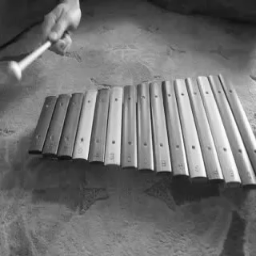

In [ ]:
#reference image before lossing compression
cv2_imshow(ref)

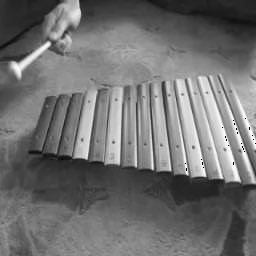

In [ ]:
#reference image after lossing compression
cv2_imshow(ref_jepg)

>>### All Frames

In [ ]:
Block_size = 1
Book=[]
Book.append(encoded)
for current in range(1,len(ved)):
  current_frame=np.array(ved[current], dtype='int')

  motion_vector=estimation(ref_jepg, current_frame, Block_size)
  a, b = compensation(ref_jepg, current_frame, Block_size, motion_vector)
  get_b_encoded, get_b_helper =jpegEnc(q, b , 'Huffman')
  print(current)
  flat_Motion_vector = [item for sublist in motion_vector for item in sublist]
  flat_Motion_vector_encoded,helper_flat_Motion_vector=use_huffenc(flat_Motion_vector)
  Book.append([flat_Motion_vector_encoded,helper_flat_Motion_vector,get_b_encoded, get_b_helper])

In [ ]:
vect=[]
vect.append(ref_jepg)
for current in range(1,len(ved)): 
  decoded=huffdec(Book[current][0],Book[current][1])

  RX_motion_vector=decoded
  RX_motion_vector=transform(decoded)

  RX_Img_b=(jpegDec(q, Book[current][2],Book[current][3], 'Huffman'))

  c, d = de_compensation(ref_jepg, asarray(RX_Img_b), Block_size, RX_motion_vector)

  cv2_imshow(d)
  vect.append(d)

In [ ]:
images = vect
filename = 'out_xyl_highq_huffman.mp4'
#converting the vector of images to a video 
make_video(filename, images)

In [ ]:
ved[0].shape

(256, 256)

In [ ]:
cm0 = comperssion_ratio(Book, 256)
print('Comperission ratio of the HIGH quan table: ', cm0)

Comperission ratio of the HIGH quan table:  1.907093841097751


### Test 2 ( low - Huffman - 1)

In [ ]:
#choose low (1) or high (2) compression or choose q = 0 for no compression
q = 1

#choose Entropy coding function from the following options: 1- Huffman 2- Arithmetic
coding_function = 'Huffman'

In [ ]:
ref = ved[0]
encoded, helper = jpegEnc(q, ref, coding_function)
Get_dec = jpegDec(q, encoded, helper, coding_function)
ref_jepg = np.asarray(Get_dec)

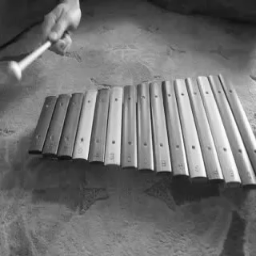

In [ ]:
#reference image before lossing compression
cv2_imshow(ref)

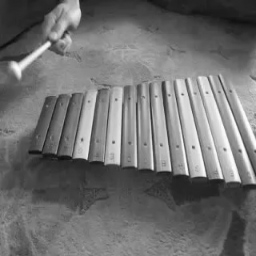

In [ ]:
#reference image after lossing compression
cv2_imshow(ref_jepg)

In [ ]:
Block_size = 1
Book1=[]
Book1.append(encoded)
for current in range(1,len(ved)):
  current_frame=np.array(ved[current], dtype='int')

  motion_vector=estimation(ref_jepg, current_frame, Block_size)
  a, b = compensation(ref_jepg, current_frame, Block_size, motion_vector)
  get_b_encoded, get_b_helper =jpegEnc(q, b , 'Huffman')
  print(current)
  flat_Motion_vector = [item for sublist in motion_vector for item in sublist]
  flat_Motion_vector_encoded,helper_flat_Motion_vector=use_huffenc(flat_Motion_vector)
  Book1.append([flat_Motion_vector_encoded,helper_flat_Motion_vector,get_b_encoded, get_b_helper])

In [ ]:
vect1=[]
vect1.append(ref_jepg)
for current in range(1,len(ved)): 
  decoded=huffdec(Book1[current][0],Book1[current][1])

  RX_motion_vector=decoded
  RX_motion_vector=transform(decoded)

  RX_Img_b=(jpegDec(q, Book1[current][2],Book1[current][3], 'Huffman'))

  c, d = de_compensation(ref_jepg, asarray(RX_Img_b), Block_size, RX_motion_vector)

  cv2_imshow(d)
  vect1.append(d)

In [ ]:
images1 = vect1
filename1 = 'out_xyl_lowq_huffman.mp4'
#converting the vector of images to a video 
make_video(filename1, images1)

In [ ]:
cm = comperssion_ratio(Book1, 256)
print('Comperission ratio of the LOW quan table: ', cm)

Comperission ratio of the LOW quan table:  1.2384285140844622


### Test 3 ( low - Huffman - 8)

In [ ]:
#choose low (1) or high (2) compression or choose q = 0 for no compression
q = 1

#choose Entropy coding function from the following options: 1- Huffman 2- Arithmetic
coding_function = 'Huffman'

In [ ]:
ref = ved[0]
encoded, helper = jpegEnc(q, ref, coding_function)
Get_dec = jpegDec(q, encoded, helper, coding_function)
ref_jepg = np.asarray(Get_dec)

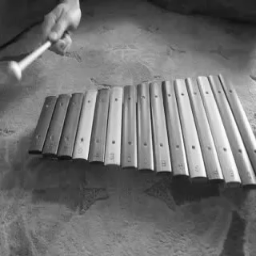

In [ ]:
#reference image before lossing compression
cv2_imshow(ref)

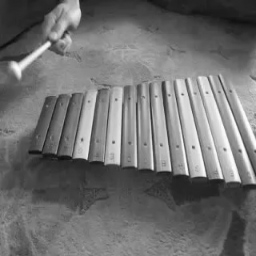

In [ ]:
#reference image after lossing compression
cv2_imshow(ref_jepg)

In [ ]:
Block_size = 8
Book3=[]
Book3.append(encoded)
for current in range(1,len(ved)):
  current_frame=np.array(ved[current], dtype='int')

  motion_vector=estimation(ref_jepg, current_frame, Block_size)
  a, b = compensation(ref_jepg, current_frame, Block_size, motion_vector)
  get_b_encoded, get_b_helper =jpegEnc(q, b , 'Huffman')
  print(current)
  flat_Motion_vector = [item for sublist in motion_vector for item in sublist]
  flat_Motion_vector_encoded,helper_flat_Motion_vector=use_huffenc(flat_Motion_vector)
  Book3.append([flat_Motion_vector_encoded,helper_flat_Motion_vector,get_b_encoded, get_b_helper])

In [ ]:
vect3=[]
vect3.append(ref_jepg)
for current in range(1,len(ved)): 
  decoded=huffdec(Book3[current][0],Book3[current][1])

  RX_motion_vector=decoded
  RX_motion_vector=transform(decoded)

  RX_Img_b=(jpegDec(q, Book3[current][2],Book3[current][3], 'Huffman'))

  c, d = de_compensation(ref_jepg, asarray(RX_Img_b), Block_size, RX_motion_vector)

  cv2_imshow(d)
  vect3.append(d)

In [ ]:
images3 = vect3
filename3 = 'out_xyl_lowq_huffman_8.mp4'
#converting the vector of images to a video 
make_video(filename3, images3)

In [ ]:
cm3 = comperssion_ratio(Book3, 256)
print('Comperission ratio of the LOW quan table _ 8 : ', cm3)

Comperission ratio of the LOW quan table _ 8 :  2.3504687147219165


### Test 4 ( high - Huffman - 8)

In [ ]:
#choose low (1) or high (2) compression or choose q = 0 for no compression
q = 2

#choose Entropy coding function from the following options: 1- Huffman 2- Arithmetic
coding_function = 'Huffman'

In [ ]:
ref = ved[0]
encoded, helper = jpegEnc(q, ref, coding_function)
Get_dec = jpegDec(q, encoded, helper, coding_function)
ref_jepg = np.asarray(Get_dec)

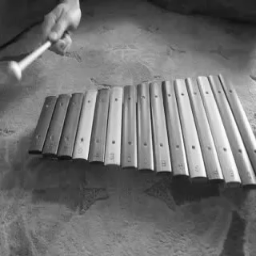

In [ ]:
#reference image before lossing compression
cv2_imshow(ref)

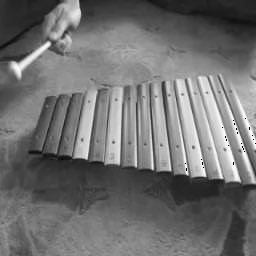

In [ ]:
#reference image after lossing compression
cv2_imshow(ref_jepg)

In [ ]:
Block_size = 8
Book4=[]
Book4.append(encoded)
for current in range(1,len(ved)):
  current_frame=np.array(ved[current], dtype='int')

  motion_vector=estimation(ref_jepg, current_frame, Block_size)
  a, b = compensation(ref_jepg, current_frame, Block_size, motion_vector)
  get_b_encoded, get_b_helper =jpegEnc(q, b , 'Huffman')
  print(current)
  flat_Motion_vector = [item for sublist in motion_vector for item in sublist]
  flat_Motion_vector_encoded,helper_flat_Motion_vector=use_huffenc(flat_Motion_vector)
  Book4.append([flat_Motion_vector_encoded,helper_flat_Motion_vector,get_b_encoded, get_b_helper])

In [ ]:
vect4=[]
vect4.append(ref_jepg)
for current in range(1,len(ved)): 
  decoded=huffdec(Book4[current][0],Book4[current][1])

  RX_motion_vector=decoded
  RX_motion_vector=transform(decoded)

  RX_Img_b=(jpegDec(q, Book4[current][2],Book4[current][3], 'Huffman'))

  c, d = de_compensation(ref_jepg, asarray(RX_Img_b), Block_size, RX_motion_vector)

  cv2_imshow(d)
  vect4.append(d)

In [ ]:
images4 = vect4
filename4 = 'out_xyl_highq_huffman_8.mp4'
#converting the vector of images to a video 
make_video(filename4, images4)

In [ ]:
cm4 = comperssion_ratio(Book4, 256)
print('Comperission ratio of the HIGH quan table _ 8 : ', cm4)

Comperission ratio of the HIGH quan table _ 8 :  6.81095884251874


>## Using Arithmetic

In [ ]:
#choose low (1) or high (2) compression or choose q = 0 for no compression
q = 2

#choose Entropy coding function from the following options: 1- Huffman 2- Arithmetic
coding_function = 'Arithmetic'

>>### First Frame

In [ ]:
ref = ved[0]
encoded, helper = jpegEnc(q, ref, coding_function)

In [ ]:
Get_dec = jpegDec(q, encoded, helper, coding_function)
ref_jepg=np.asarray(Get_dec)

In [ ]:
#reference image before lossing compression
cv2_imshow(ref)

In [ ]:
#reference image after lossing compression
cv2_imshow(ref_jepg)

In [ ]:
512*512*8/len(encoded)  # huffman low q table

3.3392172754153018

In [ ]:
512*512*8/len(encoded)  # arthmatic low q table

2142.1368743615935

>>### All Frames

In [ ]:
Block_size = 1
Book2 = []
for current in range(20,50):
  current_frame=np.array(ved[current], dtype='int')

  motion_vector=estimation(ref_jepg, current_frame, Block_size)
  a, b = compensation(ref_jepg, current_frame, Block_size, motion_vector)
  get_b_encoded, get_b_helper =jpegEnc(q, b , 'Arithmetic')
  flat_Motion_vector = [item for sublist in motion_vector for item in sublist]
  flat_Motion_vector_encoded,helper_flat_Motion_vector=use_arithenc(flat_Motion_vector, 4)
  Book2.append([flat_Motion_vector_encoded,helper_flat_Motion_vector,get_b_encoded, get_b_helper])

In [ ]:
vect2 = []
for current in range(0,30): 

  decoded=use_arithdec(Book2[current][0],Book2[current][1])

  RX_motion_vector=transform(decoded)

  RX_Img_b=(jpegDec(q, Book2[current][2],Book2[current][3], 'Arithmetic'))

  c, d = de_compensation(ref_jepg, asarray(RX_Img_b), Block_size, RX_motion_vector)

  cv2_imshow(d)
  vect2.append(d)

In [ ]:
images2 = vect2
filename2 = 'out_low_Arithmetic6.mp4'
#converting the vector of images to a video 
make_video(filename2, images2)

# Results:


https://drive.google.com/drive/folders/1EiQh2tAAzcGxh8MSjr7T8-ZH7mnJyVks
